In [1]:
from underworld import UWGeodynamics as GEO
from UWGeodynamics import visualisation as vis

loaded rc file /workspace/user_data/UWGeodynamics/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
u = GEO.UnitRegistry

In [3]:
# Characteristic values of the system
half_rate = (1.8 * u.centimeter / u.year).to(u.meter / u.second)
model_length = 60e3 * u.meter
model_height = 60e3 * u.meter
bodyforce = (3300 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2)

KL = model_length
Kt = KL / half_rate
KM = bodyforce * KL**2 * Kt**2

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"] = KM

In [4]:
Model = GEO.Model(elementRes=(64,64), 
                  minCoord=(-30 * u.kilometer, -20 * u.kilometer),
                  maxCoord=( 30 * u.kilometer,  10 * u.kilometer))

In [5]:
Model.outputDir="1_20_ColumnsTractionBottom"

In [6]:
air = Model.add_material(name="air", shape=GEO.shapes.Layer2D(top=Model.top, bottom=0.0))
background = Model.add_material(name="background", shape=GEO.shapes.Layer2D(top=air.bottom, bottom=Model.bottom))
heavyColumn = Model.add_material(name="Heavy Column", shape=GEO.shapes.Box(minX=-10.*u.kilometer, maxX=10. * u.kilometer, top=0, bottom=Model.bottom))


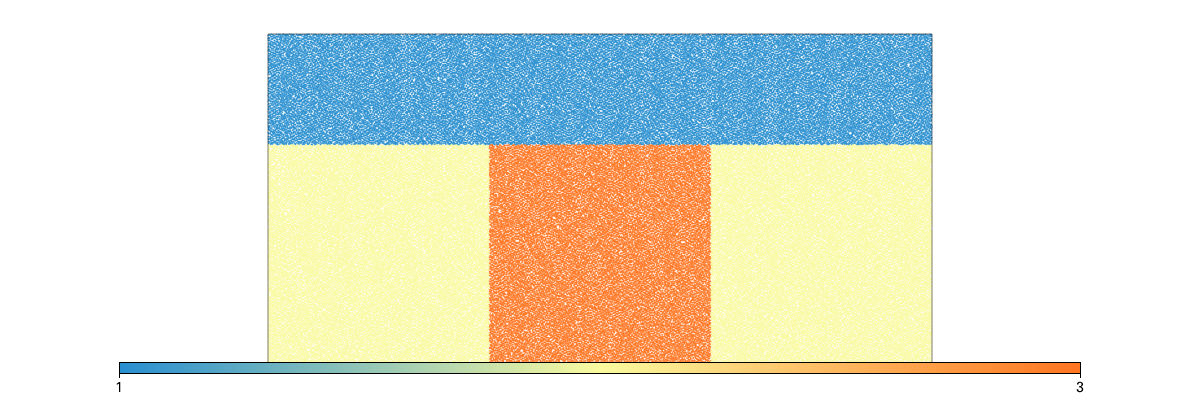

In [7]:
Fig = vis.Figure(figsize=(1200,400))
Fig.Points(Model.swarm, Model.materialField, fn_size=2.0)
Fig.save("Figure_1.png")
Fig.show()

In [8]:
air.density =  0. * u.kilogram / u.metre**3
background.density = 2700. * u.kilogram / u.metre**3
heavyColumn.density = 3300. * u.kilogram / u.metre**3

In [12]:
import numpy as np
x = GEO.nd(-30 * u.kilometer)
y = GEO.nd(-20 * u.kilometer)
P = Model.lithostatic_pressureField.evaluate(np.array([[x,y]]))
bottomPress = GEO.dimensionalise(P, u.megapascal)

In [14]:
air.viscosity         = 1e19 * u.pascal * u.second
background.viscosity  = 1e25 * u.pascal * u.second
heavyColumn.viscosity = 1e25 * u.pascal * u.second

In [15]:
Model.set_velocityBCs(left=[0.,0.], right=[0.,0.])
Model.set_stressBCs(bottom=[0., bottomPress])

In [16]:
Model.run_for(2.0 * u.year)

Running with UWGeodynamics version 2.8.1-dev-ac016ab(LecodeGeneralise)
Options:  -pc_type none -change_A11rhspresolve False -ksp_k2_type NULL -remove_constant_pressure_null_space False -restore_K False -rescale_equations False -Q22_pc_type uw -ksp_type bsscr -change_backsolve False -A11_ksp_type fgmres -A11_ksp_rtol 1e-06 -scr_ksp_type fgmres -scr_ksp_rtol 1e-05
Step:     1 Model Time: 2.0 year dt: 2.0 year (2019-03-26 05:42:50)


1

/usr/local/lib/python3.5/dist-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)



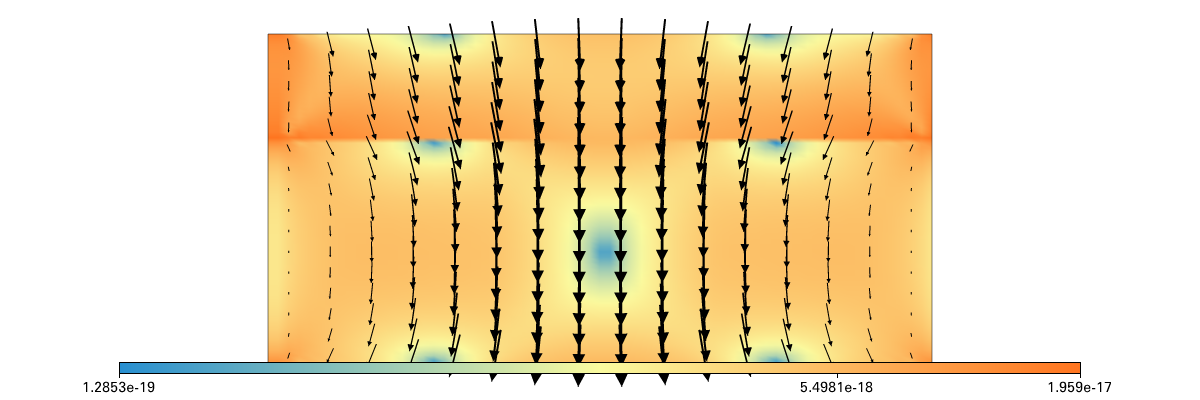

In [17]:
Fig = vis.Figure(figsize=(1200,400))
Fig.Surface(Model.mesh, GEO.dimensionalise(Model.strainRateField, 1.0/ u.second), fn_size=2.0, logScale=True)
Fig.VectorArrows(Model.mesh, Model.velocityField)
Fig.save("Figure_2.png")
Fig.show()